### Technical challenge (05-Sep-2020)

Data available at [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/transit-relacio-trams)

In [108]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime as dt
from scipy import stats
sns.set_style("darkgrid")
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

<Figure size 432x288 with 0 Axes>

### Field information:

* idTram: Section identification number (more infomrmation in [Relació de trams de la via pública de la ciutat de Barcelona](https://opendata-ajuntament.barcelona.cat/data/en/dataset/transit-relacio-trams))

* data: Date of registration (format: YYYY-MM-DD)

* estatActual: Current traffic status
(0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat) 

* estatPrevist: Expected traffic status after 15min
(0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat) 

In [2]:
# There are 8 csv files from this year.
# Load one of the files (2020-Jan) to check the contents.

tram_jan = pd.read_csv('./data/2020_01_Gener_TRAMS_TRAMS.csv')
print(tram_jan.shape)
tram_jan.head()

(4639708, 4)


,idTram,data,estatActual,estatPrevist
0,1,20200101000051,0,0
1,2,20200101000051,0,0
2,3,20200101000051,0,0
3,4,20200101000051,0,0
4,5,20200101000051,0,0


In [3]:
# Print data types
# Why: to check 'data' colmn is accessible by datetime module

tram_jan.dtypes

idTram          int64
data            int64
estatActual     int64
estatPrevist    int64
dtype: object

In [4]:
# Check if there are corrupted data:
# 1. empty rows
# 2. duplicated data

print(f'Proportion of empty rows?: {tram_jan.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {tram_jan.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [5]:
# Actually, null values in this dataset is presented with value '0'
# How many rows lacks data (value=0)?
no_data = (tram_jan['estatActual']==0) | (tram_jan['estatPrevist']==0)
print(f'How many rows lacks data (value=0)?: {len(tram_jan[no_data])}')

How many rows lacks data (value=0)?: 2257239


In [6]:
# Let's remove these raws without data:
tram_jan_clean = tram_jan[~no_data]
print(tram_jan_clean.shape)
tram_jan_clean.head()

(2382469, 4)


,idTram,data,estatActual,estatPrevist
96,97,20200101000051,1,5
142,143,20200101000051,1,5
156,157,20200101000051,1,5
187,188,20200101000051,1,5
273,274,20200101000051,3,5


### Note:
* All fields contain numeric values
* 'data' column should be converted to datetime type
* No duplicated records
* Missing values were removed

In [10]:
### Let's bring our focus to the Av. Diagonal:

diagonal = pd.read_csv('./data/Diagonal.csv')
busstop = pd.read_csv('./data/nearest_busstop_distance.csv')
speedcamera = pd.read_csv('./data/nearest_speed_camera_distance.csv')
trafficsignal = pd.read_csv('./data/nearest-traffic_signals_distance.csv')

print(diagonal.shape)
print(busstop.shape)
print(speedcamera.shape)
print(trafficsignal.shape)
diagonal.head()

(59, 4)
(118, 3)
(118, 3)
(118, 3)


,Tram,Description,Primary,Secondary
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN
1,2,Diagonal (Doctor Marañón a Ronda de Dalt),1.0,NaN
2,3,Diagonal (Doctor Marañón a Pl. Pius XII),1.0,NaN
3,4,Diagonal (Pl. Pius XII a Doctor Marañón),1.0,NaN
4,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1.0,NaN


In [11]:
print(diagonal.columns)
print(busstop.columns)
print(speedcamera.columns)
print(trafficsignal.columns)

Index(['Tram', 'Description', 'Primary', 'Secondary'], dtype='object')
Index(['Tram', 'BusstopID', 'Distance_busstop'], dtype='object')
Index(['Tram', 'MaxSpeed', 'Distance_camera'], dtype='object')
Index(['Tram', 'TrafficSignalID', 'Distance_trafficsignal'], dtype='object')


In [25]:
# Inner join all 4 dataframes on 'Tram'

diagonal_merged = diagonal.merge(busstop, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged = diagonal_merged.merge(speedcamera, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged = diagonal_merged.merge(trafficsignal, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged.head()

(118, 6)
(236, 8)
(472, 10)


,Tram,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n1311619485,0.000266
1,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n6181436151,0.000206
2,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,50.0,0.002113,n1311619485,0.000266
3,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,50.0,0.002113,n6181436151,0.000206
4,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5465386667,0.000540,80.0,0.006813,n1311619485,0.000266


In [26]:
# Let's keep one records per sectionID to keep the simplicity

diagonal_merged = diagonal_merged.drop_duplicates('Tram')
print(diagonal_merged.shape)

diagonal_merged.head()

(59, 10)


,Tram,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n1311619485,0.000266
8,2,Diagonal (Doctor Marañón a Ronda de Dalt),1.0,NaN,n5341631254,0.000937,80.0,0.006554,n687897110,0.000176
16,3,Diagonal (Doctor Marañón a Pl. Pius XII),1.0,NaN,n5341631254,0.001152,80.0,0.006827,n687897110,0.000234
24,4,Diagonal (Pl. Pius XII a Doctor Marañón),1.0,NaN,n1478113760,0.000090,60.0,0.003019,n30314626,0.003206
32,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1.0,NaN,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008


In [27]:
# Are there any null values?

diagonal_merged.isnull().mean()

Tram                      0.000000
Description               0.000000
Primary                   0.610169
Secondary                 0.627119
BusstopID                 0.000000
Distance_busstop          0.000000
MaxSpeed                  0.762712
Distance_camera           0.000000
TrafficSignalID           0.000000
Distance_trafficsignal    0.000000
dtype: float64

In [38]:
# Impute nulls in 'Primary' and 'Secondary' columns with value '0'

diagonal_merged[['Primary', 'Secondary']] = diagonal_merged[['Primary', 'Secondary']].notnull()*1
diagonal_merged.isnull().mean()

Tram                      0.000000
Description               0.000000
Primary                   0.000000
Secondary                 0.000000
BusstopID                 0.000000
Distance_busstop          0.000000
MaxSpeed                  0.762712
Distance_camera           0.000000
TrafficSignalID           0.000000
Distance_trafficsignal    0.000000
dtype: float64

In [50]:
diagonal_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 464
Data columns (total 10 columns):
Tram                      59 non-null int64
Description               59 non-null object
Primary                   59 non-null int64
Secondary                 59 non-null int64
BusstopID                 59 non-null object
Distance_busstop          59 non-null float64
MaxSpeed                  14 non-null float64
Distance_camera           59 non-null float64
TrafficSignalID           59 non-null object
Distance_trafficsignal    59 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 5.1+ KB


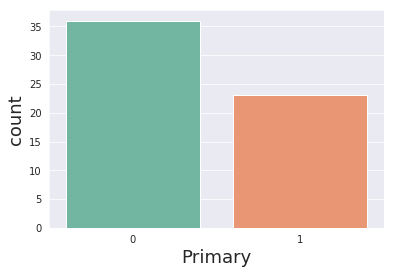

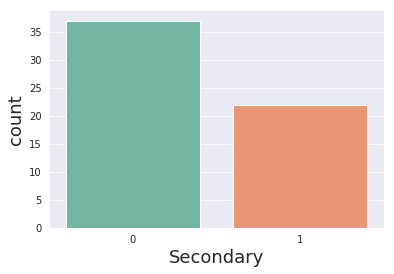

In [60]:
# Let's check distribution of numeric variables

sns.countplot(diagonal_merged.Primary, palette='Set2')
plt.show()
sns.countplot(diagonal_merged.Secondary, palette='Set2')
plt.show()

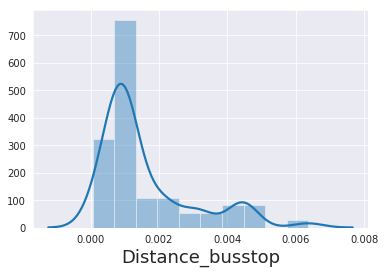

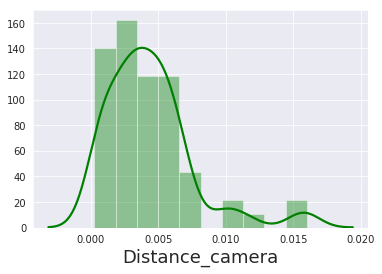

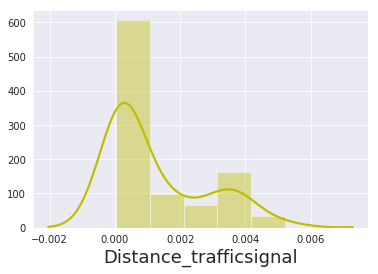

In [67]:
sns.distplot(diagonal_merged.Distance_busstop)
plt.show()

sns.distplot(diagonal_merged.Distance_camera, color='g')
plt.show()

sns.distplot(diagonal_merged.Distance_trafficsignal, color='y')
plt.show()

Check agian the jan-2020 data focusing on these IDs only

In [40]:
# Extract Tram IDs in Diagonal:

sectionID = diagonal_merged.Tram.unique()
sectionID

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  19,  26,  27,
        47,  48,  49,  57,  63,  89, 101, 103, 104, 105, 106, 107, 122,
       180, 196, 197, 206, 239, 254, 256, 257, 258, 259, 260, 261, 265,
       272, 273, 279, 320, 360, 386, 387, 401, 402, 403, 413, 421, 423,
       424, 425, 426, 431, 447, 451, 517])

In [44]:
id_jan = [id for id in tram_jan_clean.idTram.unique() if id in sectionID]
len(id_jan)

51

In [49]:
mask = tram_jan_clean['idTram'] .isin(id_jan)
jan_2020 = tram_jan_clean[mask]

print(jan_2020.shape)
jan_2020.head()

(297919, 4)


,idTram,data,estatActual,estatPrevist
1116,63,20200101001052,1,1
1175,122,20200101001052,1,2
1233,180,20200101001052,1,2
1259,206,20200101001052,2,2
1318,265,20200101001052,2,2


In [68]:
# Modify the data:
# 1. Change column names to english
# 2. Change 'date' column into datetime type

new_names = {"idTram": "Tram", "data": "date", "estatActual": "CurrentState", "estatPrevist": "ExpectedState"}
jan_2020 = jan_2020.rename(columns=new_names)
    
# 2. 'date' column as a datetime type
jan_2020['date'] = pd.to_datetime(jan_2020['date'].astype(str), yearfirst=True)

jan_2020.head()

,Tram,date,CurrentState,ExpectedState
1116,63,2020-01-01 00:10:52,1,1
1175,122,2020-01-01 00:10:52,1,2
1233,180,2020-01-01 00:10:52,1,2
1259,206,2020-01-01 00:10:52,2,2
1318,265,2020-01-01 00:10:52,2,2


In [78]:
# Let's further modity the 'date' column

#1. Add day of the week info by creating a new column:
jan_2020['Weekday'] = jan_2020.date.dt.weekday_name

#2. Let's introduce 'rush hour' to our data
rush_hour = jan_2020.CurrentState >= 5
jan_2020_rh = jan_2020[rush_hour]

jan_2020_rh.head()

,Tram,date,CurrentState,ExpectedState,Weekday
4473,258,2020-01-01 00:40:55,5,5,Wednesday
9805,320,2020-01-01 01:30:52,5,4,Wednesday
11324,258,2020-01-01 01:45:52,5,4,Wednesday
15602,320,2020-01-01 02:25:53,5,4,Wednesday
17648,258,2020-01-01 02:45:53,5,5,Wednesday


Text(0.5,0,'Section ID')

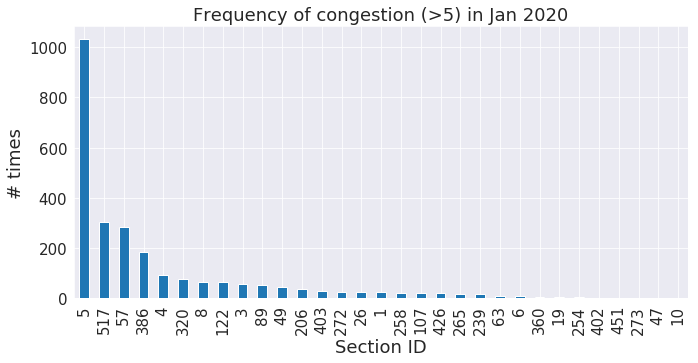

In [93]:
plt.figure(figsize=(11,5))
jan_2020_rh.Tram.value_counts().plot(kind='bar')
plt.title('Frequency of congestion (>5) in Jan 2020')
plt.ylabel('# times')
plt.xlabel('Section ID')

In [187]:
# Let's look at top 10
top10_id = jan_2020_rh.Tram.value_counts()[:10].index

mask = jan_2020_rh['Tram'] .isin(top10_id )
top10_congested = jan_2020_rh[mask]

print(top10_congested.shape)
top10_congested.head()

(2211, 5)


,Tram,date,CurrentState,ExpectedState,Weekday
9805,320,2020-01-01 01:30:52,5,4,Wednesday
15602,320,2020-01-01 02:25:53,5,4,Wednesday
100976,320,2020-01-01 15:55:56,5,5,Wednesday
102030,320,2020-01-01 16:05:53,5,5,Wednesday
200579,320,2020-01-02 07:40:55,5,5,Thursday


In [188]:
top10_id

Int64Index([5, 517, 57, 386, 4, 320, 8, 122, 3, 89], dtype='int64')

In [189]:
# Join with diagonal_merged attributes:

top10_jan = top10_congested.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(top10_jan.shape)
top10_jan.head()

(2211, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,320,2020-01-01 01:30:52,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
1,320,2020-01-01 02:25:53,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
2,320,2020-01-01 15:55:56,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
3,320,2020-01-01 16:05:53,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
4,320,2020-01-02 07:40:55,5,5,Thursday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291


In [190]:
# Create the joined data for the rest of the Section IDs:
rest_jan = jan_2020_rh[~mask]
rest_jan = rest_jan.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(rest_jan.shape)
rest_jan.head()

(312, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,258,2020-01-01 00:40:55,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
1,258,2020-01-01 01:45:52,5,4,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
2,258,2020-01-01 02:45:53,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
3,258,2020-01-01 03:10:53,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
4,258,2020-01-01 04:10:52,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127


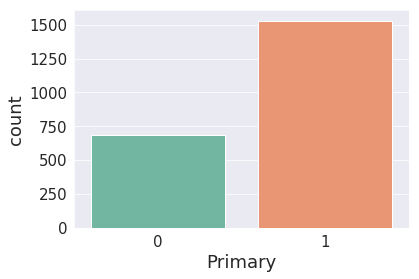

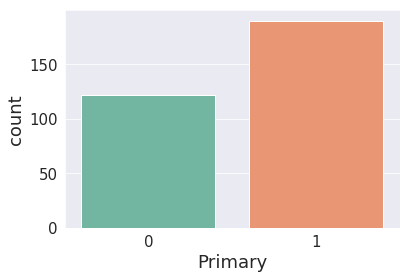

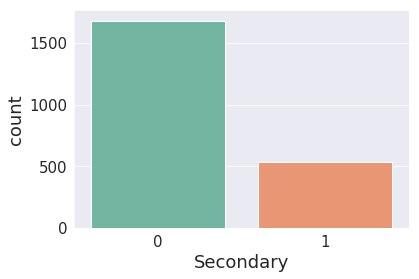

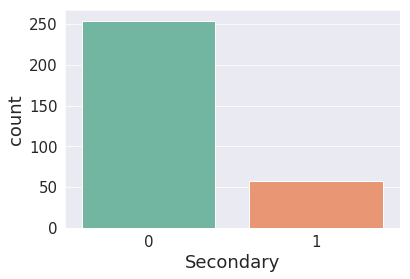

In [191]:
# Let's check distribution of numeric variables

sns.countplot(top10_jan.Primary, palette='Set2')
plt.show()
sns.countplot(rest_jan.Primary, palette='Set2')
plt.show()

sns.countplot(top10_jan.Secondary, palette='Set2')
plt.show()
sns.countplot(rest_jan.Secondary, palette='Set2')
plt.show()

In [192]:
# ttest with the rest of the diagonal sections:

t_primary, p_primary = stats.ttest_ind(top10_jan.Primary, rest_jan.Primary)
t_secondary, p_secondary = stats.ttest_ind(top10_jan.Secondary, rest_jan.Secondary)

print(round(p_primary, 5))
print(round(p_secondary, 5))

0.00338
0.03392


In [193]:
print(f'top5 mean: {np.mean(top10_jan.Distance_busstop)}')
print(f'top5 std: {np.std(top10_jan.Distance_busstop)}')

print(f'rest mean: {np.mean(rest_jan.Distance_busstop)}')
print(f'rest std: {np.std(rest_jan.Distance_busstop)}')
print('-'*30)

print(f'top5 mean: {np.mean(top10_jan.Distance_camera)}')
print(f'top5 std: {np.std(top10_jan.Distance_camera)}')

print(f'rest mean: {np.mean(rest_jan.Distance_camera)}')
print(f'rest std: {np.std(rest_jan.Distance_camera)}')
print('-'*30)

print(f'top5 mean: {np.mean(top10_jan.Distance_trafficsignal)}')
print(f'top5 std: {np.std(top10_jan.Distance_trafficsignal)}')

print(f'rest mean: {np.mean(rest_jan.Distance_trafficsignal)}')
print(f'rest std: {np.std(rest_jan.Distance_trafficsignal)}')

top5 mean: 0.0015766926470976886
top5 std: 0.0021575041711928322
rest mean: 0.0016642782948130125
rest std: 0.0014252366466758883
------------------------------
top5 mean: 0.0034149768038575314
top5 std: 0.0010161832835874987
rest mean: 0.004410752507566509
rest std: 0.004084519727003902
------------------------------
top5 mean: 0.0026649068678695565
top5 std: 0.0014693163707580883
rest mean: 0.001300874653783909
rest std: 0.0014853291091070184


Text(0.5,0,'Distance unit')

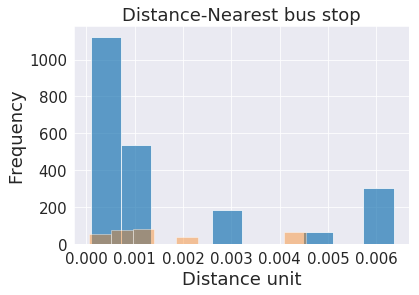

In [194]:
top10_jan.Distance_busstop.plot(kind='hist', alpha=.7)
rest_jan.Distance_busstop.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest bus stop')
plt.xlabel('Distance unit')

Text(0.5,0,'Distance unit')

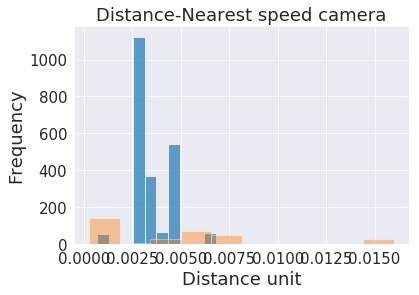

In [195]:
top10_jan.Distance_camera.plot(kind='hist', alpha=.7)
rest_jan.Distance_camera.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest speed camera')
plt.xlabel('Distance unit')

Text(0.5,0,'Distance unit')

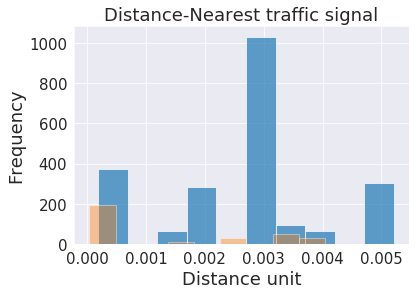

In [196]:
top10_jan.Distance_trafficsignal.plot(kind='hist', alpha=.7)
rest_jan.Distance_trafficsignal.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest traffic signal')
plt.xlabel('Distance unit')

In [179]:
# Is this tendency same in completely other moment of the year?
# May 2019 (more active moment of the year, only 1 festivo as in Jan 2020)

may_ = pd.read_csv('./data/2019_05_Maig_TRAMS_TRAMS.csv')
print(may_.shape)
may_.head()

(4637618, 4)


,idTram,data,estatActual,estatPrevist
0,1,20190501000552,1,0
1,2,20190501000552,1,0
2,3,20190501000552,1,0
3,4,20190501000552,1,0
4,5,20190501000552,1,0


In [180]:
# Check if there are corrupted data:
# 1. empty rows
# 2. duplicated data

print(f'Proportion of empty rows?: {may_.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {may_.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [181]:
# Actually, null values in this dataset is presented with value '0'
# How many rows lacks data (value=0)?
no_data = (may_['estatActual']==0) | (may_['estatPrevist']==0)
print(f'How many rows lacks data (value=0)?: {len(may_[no_data])}')

How many rows lacks data (value=0)?: 2378753


In [182]:
# Let's remove these raws without data:
may_2019_clean = may_[~no_data]
print(may_2019_clean.shape)
may_2019_clean.head()

(2258865, 4)


,idTram,data,estatActual,estatPrevist
36,37,20190501000552,4,5
56,57,20190501000552,1,5
57,58,20190501000552,1,5
143,144,20190501000552,1,5
276,277,20190501000552,2,5


In [183]:
mask = may_2019_clean['idTram'] .isin(id_jan)
may_2019 = may_2019_clean[mask]

print(may_2019.shape)
may_2019.head()

(278133, 4)


,idTram,data,estatActual,estatPrevist
56,57,20190501000552,1,5
319,320,20190501000552,5,5
589,57,20190501000053,1,5
852,320,20190501000053,1,5
1066,1,20190501001053,1,1


In [184]:
# Modify the data:
# 1. Change column names to english
# 2. Change 'date' column into datetime type

may_2019 = may_2019.rename(columns=new_names)
    
# 2. 'date' column as a datetime type
may_2019['date'] = pd.to_datetime(may_2019['date'].astype(str), yearfirst=True)

may_2019.head()

,Tram,date,CurrentState,ExpectedState
56,57,2019-05-01 00:05:52,1,5
319,320,2019-05-01 00:05:52,5,5
589,57,2019-05-01 00:00:53,1,5
852,320,2019-05-01 00:00:53,1,5
1066,1,2019-05-01 00:10:53,1,1


In [185]:
# Let's further modity the 'date' column

#1. Add day of the week info by creating a new column:
may_2019['Weekday'] = may_2019.date.dt.weekday_name

#2. Let's introduce 'rush hour' to our data
rush_hour = may_2019.CurrentState >= 5
may_2019_rh = may_2019[rush_hour]

may_2019_rh.head()

,Tram,date,CurrentState,ExpectedState,Weekday
319,320,2019-05-01 00:05:52,5,5,Wednesday
2451,320,2019-05-01 00:20:52,5,4,Wednesday
10979,320,2019-05-01 01:40:52,5,2,Wednesday
15243,320,2019-05-01 02:20:53,5,5,Wednesday
18974,320,2019-05-01 02:55:52,5,5,Wednesday


Text(0.5,0,'Section ID')

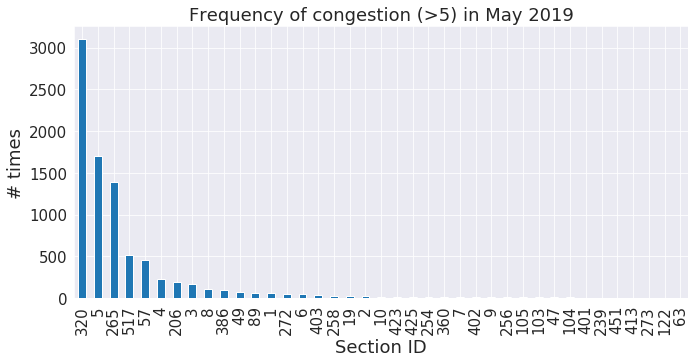

In [197]:
plt.figure(figsize=(11,5))
may_2019_rh.Tram.value_counts().plot(kind='bar')
plt.title('Frequency of congestion (>5) in May 2019')
plt.ylabel('# times')
plt.xlabel('Section ID')

In [201]:
top10_may_id = top10_may['Tram'].unique()
[id for id in top10_id if id in top10_may_id]

[5, 517, 57, 386, 4, 320, 8, 3]

In [167]:
# Let's look at top 10
top10_may = may_2019_rh.Tram.value_counts()[:10].index

mask = may_2019_rh['Tram'].isin(top10_may)
top10_may = may_2019_rh[mask]

print(top10_may.shape)

(7958, 5)


array([320, 206,   4,  57,   8,   5, 517, 386,   3, 265])

In [202]:
# Join with diagonal_merged attributes:

top10_may = top10_may.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(top10_may.shape)
top10_may.head()

(7958, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,320,2019-05-01 00:05:52,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
1,320,2019-05-01 00:20:52,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
2,320,2019-05-01 01:40:52,5,2,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
3,320,2019-05-01 02:20:53,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
4,320,2019-05-01 02:55:52,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291


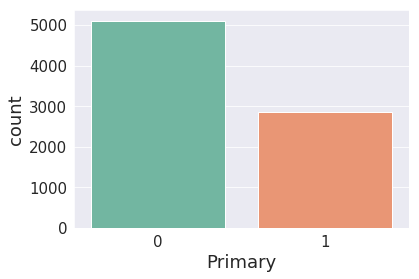

NameError: name 'rest_may' is not defined

In [203]:
# Let's check distribution of numeric variables

sns.countplot(top10_may.Primary, palette='Set2')
plt.show()
sns.countplot(rest_may.Primary, palette='Set2')
plt.show()

sns.countplot(top10_may.Secondary, palette='Set2')
plt.show()
sns.countplot(rest_may.Secondary, palette='Set2')
plt.show()